# Relation Map

This notebook inspects registered relations and maps how variables connect.

What you get:
- A relation table (outputs, inputs, tags).
- A variable map (who produces/consumes each variable).
- A DOT graph you can render with Graphviz if desired.


In [1]:
from __future__ import annotations

from collections import defaultdict
from pathlib import Path
import sys

repo_root = Path().resolve()
src_path = repo_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from fusdb.reactor_class import Reactor
from fusdb.reactor_util import ALLOWED_RELATION_DOMAINS


In [2]:
def collect_relations(tags=None, require_all=False):
    # Return registered relations for the requested tags.
    tags = tuple(tags) if tags is not None else ALLOWED_RELATION_DOMAINS
    return Reactor.get_relations_with_tags(tags, require_all=require_all)


def relation_records(relations):
    records = []
    for tags, rel in relations:
        output = rel.variables[0] if rel.variables else ""
        inputs = list(rel.variables[1:]) if rel.variables else []
        records.append({
            "relation": rel.name,
            "output": output,
            "inputs": inputs,
            "tags": list(tags),
        })
    return records


In [3]:
from html import escape
from IPython.display import HTML, display


def _format_list(items):
    return ", ".join(escape(str(item)) for item in items)


def display_relation_table(records, limit=None):
    rows = records if limit is None else records[:limit]
    parts = [
        "<table>",
        "<thead><tr><th>Relation</th><th>Output</th><th>Inputs</th><th>Tags</th></tr></thead>",
        "<tbody>",
    ]
    for rec in rows:
        parts.append(
            "<tr>"
            f"<td>{escape(rec['relation'])}</td>"
            f"<td>{escape(rec['output'])}</td>"
            f"<td>{_format_list(rec['inputs'])}</td>"
            f"<td>{_format_list(rec['tags'])}</td>"
            "</tr>"
        )
    parts.append("</tbody></table>")
    display(HTML("".join(parts)))


def build_variable_map(records):
    producers = defaultdict(list)
    consumers = defaultdict(list)
    for rec in records:
        output = rec["output"]
        if output:
            producers[output].append(rec["relation"])
        for inp in rec["inputs"]:
            consumers[inp].append(rec["relation"])
    variables = sorted(set(producers) | set(consumers))
    rows = []
    for var in variables:
        rows.append({
            "variable": var,
            "produced_by": producers.get(var, []),
            "used_by": consumers.get(var, []),
        })
    return rows


def display_variable_table(rows, limit=None):
    rows = rows if limit is None else rows[:limit]
    parts = [
        "<table>",
        "<thead><tr><th>Variable</th><th>Produced by</th><th>used by</th></tr></thead>",
        "<tbody>",
    ]
    for rec in rows:
        parts.append(
            "<tr>"
            f"<td>{escape(rec['variable'])}</td>"
            f"<td>{_format_list(rec['produced_by'])}</td>"
            f"<td>{_format_list(rec['used_by'])}</td>"
            "</tr>"
        )
    parts.append("</tbody></table>")
    display(HTML("".join(parts)))


In [4]:
relations = collect_relations()
records = relation_records(relations)

print(f"Relations found: {len(records)}")
display_relation_table(records)


Relations found: 42


Relation,Output,Inputs,Tags
Total auxiliary power,P_aux,"P_NBI, P_ICRF, P_LHCD","power_exhaust, auxiliary"
tau_E_hubbard_nominal,tau_E,"I_p, B0, dnla20, P_loss","confinement, tokamak, I-mode"
tau_E_iter_ipb98y2,tau_E,"I_p, B0, n_la, P_loss, R, kappa_ipb, A, afuel","confinement, tokamak, H-mode"
Thermal pressure,p_th,"n_e, T_e, n_i, T_i",plasma
Thermal stored energy,W_th,"p_th, V_p",plasma
Energy confinement time,tau_E,"W_th, P_loss",plasma
Major radius,R,"R_max, R_min",geometry
Aspect ratio,A,"R, a",geometry
Elongation,kappa,"Z_max, Z_min, R_max, R_min",geometry
Elongation 95%,kappa,kappa_95,"geometry, tokamak"


In [5]:
variable_rows = build_variable_map(records)
print(f"Variables connected: {len(variable_rows)}")
display_variable_table(variable_rows)


Variables connected: 61


Variable,Produced by,used by
A,Aspect ratio,"tau_E_iter_ipb98y2, ST elongation vs aspect ratio, ST triangularity vs aspect ratio"
B0,,"tau_E_hubbard_nominal, tau_E_iter_ipb98y2, Troyon beta limit, Sudo density limit, Toroidal beta, Normalized beta"
B_p,,Poloidal beta
I_p,,"tau_E_hubbard_nominal, tau_E_iter_ipb98y2, Troyon beta limit, Greenwald density limit, Normalized beta"
P_ICRF,,Total auxiliary power
P_LHCD,,Total auxiliary power
P_NBI,,Total auxiliary power
P_aux,Total auxiliary power,Total plasma heating
P_charged,Charged fusion power,Total plasma heating
P_fus_DDn_He3,,Charged fusion power


In [6]:

    def _dot_id(text):
        cleaned = "".join(ch if ch.isalnum() or ch == "_" else "_" for ch in text)
        return f"v_{cleaned}"


    def relations_to_dot(records):
        lines = [
            'digraph fusdb_relations {',
            '  rankdir=LR;',
            '  node [fontname="Helvetica"];',
        ]
        variable_nodes = set()
        for idx, rec in enumerate(records):
            rel_id = f"rel_{idx}"
            rel_label = rec["relation"].replace("\"", "\\\"")
            lines.append(f'  {rel_id} [shape=box, label="{rel_label}"];')
            for inp in rec["inputs"]:
                var_id = _dot_id(inp)
                if var_id not in variable_nodes:
                    variable_nodes.add(var_id)
                    lines.append(f'  {var_id} [shape=ellipse, label="{inp}"];')
                lines.append(f'  {var_id} -> {rel_id};')
            output = rec["output"]
            if output:
                out_id = _dot_id(output)
                if out_id not in variable_nodes:
                    variable_nodes.add(out_id)
                    lines.append(f'  {out_id} [shape=ellipse, label="{output}"];')
                lines.append(f'  {rel_id} -> {out_id};')
        lines.append('}')
        return "\\n".join(lines)


    dot_graph = relations_to_dot(records)
    print(dot_graph)
    

digraph fusdb_relations {\n  rankdir=LR;\n  node [fontname="Helvetica"];\n  rel_0 [shape=box, label="Total auxiliary power"];\n  v_P_NBI [shape=ellipse, label="P_NBI"];\n  v_P_NBI -> rel_0;\n  v_P_ICRF [shape=ellipse, label="P_ICRF"];\n  v_P_ICRF -> rel_0;\n  v_P_LHCD [shape=ellipse, label="P_LHCD"];\n  v_P_LHCD -> rel_0;\n  v_P_aux [shape=ellipse, label="P_aux"];\n  rel_0 -> v_P_aux;\n  rel_1 [shape=box, label="tau_E_hubbard_nominal"];\n  v_I_p [shape=ellipse, label="I_p"];\n  v_I_p -> rel_1;\n  v_B0 [shape=ellipse, label="B0"];\n  v_B0 -> rel_1;\n  v_dnla20 [shape=ellipse, label="dnla20"];\n  v_dnla20 -> rel_1;\n  v_P_loss [shape=ellipse, label="P_loss"];\n  v_P_loss -> rel_1;\n  v_tau_E [shape=ellipse, label="tau_E"];\n  rel_1 -> v_tau_E;\n  rel_2 [shape=box, label="tau_E_iter_ipb98y2"];\n  v_I_p -> rel_2;\n  v_B0 -> rel_2;\n  v_n_la [shape=ellipse, label="n_la"];\n  v_n_la -> rel_2;\n  v_P_loss -> rel_2;\n  v_R [shape=ellipse, label="R"];\n  v_R -> rel_2;\n  v_kappa_ipb [shape=elli

## Relation Graph

This plot shows variables as nodes and relations as colored edges. Use `max_relations` or filter
the `records` to keep the graph readable.


/tmp/ipykernel_375468/4129880250.py:103: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(


(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

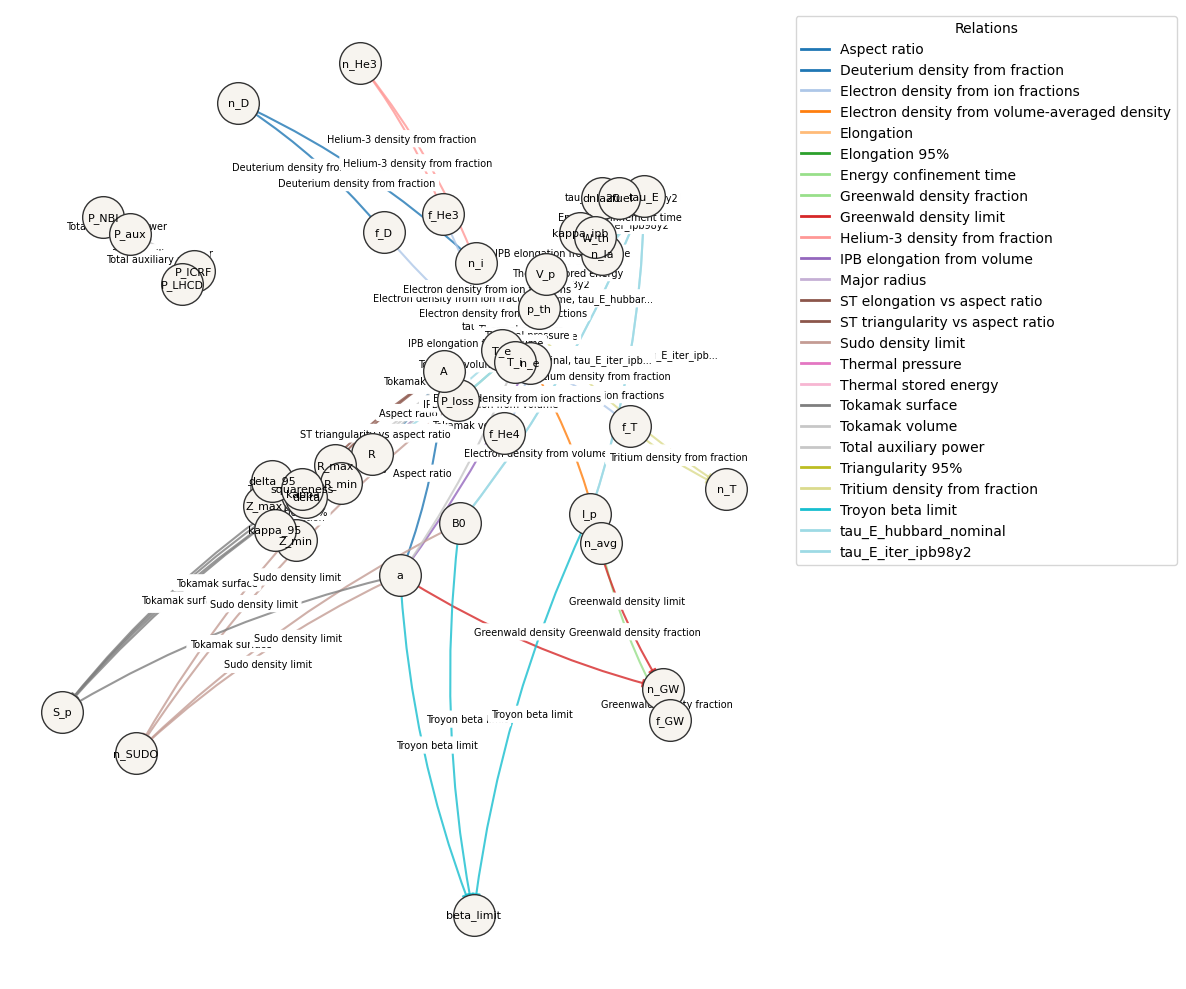

In [7]:
import matplotlib.pyplot as plt
from collections import defaultdict

try:
    import networkx as nx
except Exception as exc:
    print("networkx is not available:", exc)
    print("Install with `pip install networkx` if you want the plot.")
    nx = None


def _relation_edges(records):
    edges = []
    for rec in records:
        output = rec["output"]
        if not output:
            continue
        rel = rec["relation"]
        for inp in rec["inputs"]:
            edges.append((inp, output, rel))
    return edges


def _filter_edges_by_relation_limit(edges, max_relations):
    if max_relations is None:
        return edges
    allowed = []
    filtered = []
    for inp, out, rel in edges:
        if rel not in allowed:
            if len(allowed) >= max_relations:
                continue
            allowed.append(rel)
        filtered.append((inp, out, rel))
    return filtered


def _relation_color_map(relations):
    cmap = plt.get_cmap("tab20", max(len(relations), 1))
    return {rel: cmap(i) for i, rel in enumerate(relations)}


def _edge_label_map(edges, max_label_len=None):
    label_map = defaultdict(list)
    for inp, out, rel in edges:
        label_map[(inp, out)].append(rel)
    edge_labels = {}
    for (inp, out), rels in label_map.items():
        uniq = sorted(set(rels))
        label = ", ".join(uniq)
        if max_label_len is not None and len(label) > max_label_len:
            if max_label_len > 3:
                label = label[: max_label_len - 3] + "..."
            else:
                label = label[: max_label_len]
        edge_labels[(inp, out)] = label
    return edge_labels


def plot_relation_graph(
    records,
    max_relations=None,
    layout="spring",
    seed=7,
    draw_edge_labels=True,
    max_label_len=40,
):
    if nx is None:
        return None
    edges = _relation_edges(records)
    edges = _filter_edges_by_relation_limit(edges, max_relations)
    if not edges:
        print("No relations to plot.")
        return None

    relations = sorted({rel for _, _, rel in edges})
    rel_colors = _relation_color_map(relations)

    graph = nx.MultiDiGraph()
    for inp, out, rel in edges:
        graph.add_edge(inp, out, relation=rel, color=rel_colors[rel])

    if layout == "circular":
        pos = nx.circular_layout(graph)
    elif layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(graph)
    else:
        pos = nx.spring_layout(graph, seed=seed)

    fig, ax = plt.subplots(figsize=(12, 10))
    nx.draw_networkx_nodes(
        graph,
        pos,
        node_color="#f7f4ef",
        edgecolors="#333",
        node_size=900,
        ax=ax,
    )
    nx.draw_networkx_labels(graph, pos, font_size=8, ax=ax)

    for rel in relations:
        rel_edges = [(u, v) for u, v, k, d in graph.edges(keys=True, data=True) if d.get("relation") == rel]
        nx.draw_networkx_edges(
            graph,
            pos,
            edgelist=rel_edges,
            edge_color=[rel_colors[rel]] * len(rel_edges),
            arrows=True,
            arrowsize=12,
            width=1.5,
            alpha=0.8,
            connectionstyle="arc3,rad=0.08",
            ax=ax,
        )

    if draw_edge_labels:
        edge_labels = _edge_label_map(edges, max_label_len=max_label_len)
        label_graph = nx.DiGraph()
        label_graph.add_edges_from(edge_labels.keys())
        nx.draw_networkx_edge_labels(
            label_graph,
            pos,
            edge_labels=edge_labels,
            font_size=7,
            rotate=False,
            ax=ax,
        )

    handles = [plt.Line2D([0], [0], color=rel_colors[rel], lw=2, label=rel) for rel in relations]
    ax.legend(handles=handles, bbox_to_anchor=(1.02, 1), loc="upper left", title="Relations")
    ax.set_axis_off()
    fig.tight_layout()
    return fig, ax


# Example: limit to the first 25 relations to keep the plot readable
plot_relation_graph(records, max_relations=25, layout="spring", draw_edge_labels=True)


## Interactive Graph

This uses PyVis (if installed) to create a zoomable HTML graph.


In [8]:

    import json
    from collections import defaultdict
    from pathlib import Path

    try:
        from pyvis.network import Network
    except Exception as exc:
        print("pyvis is not available:", exc)
        print("Install with `pip install pyvis` if you want the interactive plot.")
        Network = None


    def _shorten_label(text, max_len):
        if max_len is None:
            return str(text)
        text = str(text)
        if len(text) <= max_len:
            return text
        if max_len <= 3:
            return text[:max_len]
        return text[: max_len - 3] + "..."


    def _load_variable_info():
        try:
            import yaml
        except Exception as exc:
            print("PyYAML is not available:", exc)
            print("Install with `pip install pyyaml` if you want variable details.")
            return {}, {}

        path = Path("src/fusdb/registry/allowed_variables.yaml")
        data = yaml.safe_load(path.read_text()) or {}
        info = {}
        alias_map = defaultdict(list)
        for name, meta in data.items():
            if not isinstance(meta, dict):
                continue
            lines = [f"{name}"]
            default_unit = meta.get("default_unit")
            if default_unit:
                lines.append(f"unit: {default_unit}")
            aliases = meta.get("aliases")
            alias_list = []
            if aliases:
                if isinstance(aliases, (list, tuple)):
                    alias_list = [str(a) for a in aliases]
                    alias_text = ", ".join(alias_list)
                else:
                    alias_list = [str(aliases)]
                    alias_text = alias_list[0]
                lines.append(f"aliases: {alias_text}")
                for alias in alias_list:
                    if alias:
                        alias_map[alias].append(name)
            constraints = meta.get("constraints")
            if constraints:
                if isinstance(constraints, (list, tuple)):
                    constraint_text = "; ".join(str(c) for c in constraints)
                else:
                    constraint_text = str(constraints)
                lines.append(f"constraints: {constraint_text}")
            desc = meta.get("description")
            if desc:
                if isinstance(desc, (list, tuple)):
                    desc_text = " ".join(str(d).strip() for d in desc)
                else:
                    desc_text = str(desc)
                lines.append(f"description: {desc_text}")
            info[name] = "\n".join(lines)
        return info, dict(alias_map)
    def _load_relation_info():
        import inspect
        import importlib
        import pkgutil
        import fusdb.relations as relations_pkg

        info = {}
        for modinfo in pkgutil.walk_packages(relations_pkg.__path__, relations_pkg.__name__ + "."):
            module = importlib.import_module(modinfo.name)
            for obj in module.__dict__.values():
                rel = getattr(obj, "relation", None)
                if rel is None or not hasattr(rel, "name"):
                    continue
                try:
                    source = inspect.getsource(obj)
                except Exception:
                    source = f"{module.__name__}.{getattr(obj, '__name__', '<unknown>')} (source unavailable)"
                entry = {
                    "function": getattr(obj, "__name__", "<unknown>"),
                    "module": module.__name__,
                    "source": source,
                }
                info.setdefault(rel.name, []).append(entry)
        return info


    def _build_connection_maps(records):
        var_inputs = defaultdict(set)
        var_outputs = defaultdict(set)
        rel_inputs = defaultdict(set)
        rel_outputs = defaultdict(set)
        for rec in records:
            rel = rec["relation"]
            output = rec["output"]
            inputs = rec["inputs"]
            if output:
                var_outputs[output].add(rel)
                rel_outputs[rel].add(output)
            for inp in inputs:
                var_inputs[inp].add(rel)
                rel_inputs[rel].add(inp)
        var_map = {
            name: {
                "produced_by": sorted(var_outputs.get(name, [])),
                "used_by": sorted(var_inputs.get(name, [])),
            }
            for name in sorted(set(var_inputs) | set(var_outputs))
        }
        rel_map = {
            name: {
                "inputs": sorted(rel_inputs.get(name, [])),
                "outputs": sorted(rel_outputs.get(name, [])),
            }
            for name in sorted(set(rel_inputs) | set(rel_outputs))
        }
        return var_map, rel_map


    def _relation_tag_map(records):
        tag_map = defaultdict(set)
        for rec in records:
            rel = rec.get("relation")
            for tag in rec.get("tags") or []:
                if tag:
                    tag_map[rel].add(str(tag))
        return {name: sorted(tags) for name, tags in tag_map.items()}


    def _json_for_html(obj):
        text = json.dumps(obj, ensure_ascii=True)
        return text.replace("</", "<\\/")


    def plot_relation_graph_interactive(
        records,
        max_relations=None,
        output_file="relation_graph.html",
        label_max_len=40,
    ):
        if Network is None:
            return None
        edges = _relation_edges(records)
        edges = _filter_edges_by_relation_limit(edges, max_relations)
        if not edges:
            print("No relations to plot.")
            return None

        relations = sorted({rel for _, _, rel in edges})
        rel_colors = _relation_color_map(relations)
        try:
            from matplotlib.colors import to_hex
        except Exception:
            def to_hex(color):
                return "#888888"

        nodes = sorted({inp for inp, _, _ in edges} | {out for _, out, _ in edges})
        variable_info, variable_aliases = _load_variable_info()
        relation_info = _load_relation_info()
        var_connections, rel_connections = _build_connection_maps(records)
        relation_tags = _relation_tag_map(records)

        net = Network(height="800px", width="100%", directed=True, notebook=True)
        net.barnes_hut()
        options = {
            "nodes": {
                "shape": "dot",
                "size": 18,
                "font": {"size": 20, "face": "monospace"},
            },
            "edges": {
                "arrows": {"to": {"enabled": True}},
                "font": {"size": 16, "align": "middle"},
            },
            "interaction": {"hover": True},
            "physics": {"barnesHut": {"springLength": 140, "springConstant": 0.03}},
        }
        net.set_options(json.dumps(options))

        for node in nodes:
            label = _shorten_label(node, label_max_len)
            net.add_node(node, label=label, title=str(node))
        for inp, out, rel in edges:
            label = _shorten_label(rel, label_max_len)
            net.add_edge(
                inp,
                out,
                label=label,
                title=str(rel),
                color=to_hex(rel_colors[rel]),
                relation=str(rel),
            )

        html = net.generate_html(notebook=False)
        inject = """
        <style>
          #relation-toolbox {
            position: fixed;
            top: 12px;
            right: 12px;
            z-index: 9999;
            background: #fff;
            border: 1px solid #ccc;
            padding: 10px;
            max-width: 420px;
            box-shadow: 0 2px 6px rgba(0, 0, 0, 0.15);
            font-family: monospace;
          }
          #relation-toolbox label,
          #relation-toolbox input,
          #relation-toolbox button,
          #relation-toolbox pre {
            font-size: 14px;
          }
          #relation-toolbox input {
            width: 260px;
            padding: 6px;
          }
          #relation-toolbox button {
            margin-left: 6px;
            padding: 6px 10px;
          }
          #search-suggestions {
            margin-top: 6px;
            border: 1px solid #ddd;
            background: #fafafa;
            max-height: 140px;
            overflow: auto;
            display: none;
          }
          #search-suggestions .suggestion {
            padding: 4px 6px;
            cursor: pointer;
          }
          #search-suggestions .suggestion:hover {
            background: #eef;
          }
          #relation-toolbox pre {
            margin: 8px 0 0 0;
            padding: 8px;
            border: 1px solid #ddd;
            max-height: 320px;
            overflow: auto;
            white-space: pre-wrap;
          }
        </style>
        <div id="relation-toolbox">
          <label for="search-input"><strong>Search</strong></label><br />
          <input id="search-input" type="text" placeholder="Variable or relation" />
          <button id="search-button">Go</button>
          <div id="search-suggestions"></div>
          <div style="margin-top:8px;"><strong>Info</strong></div>
          <pre id="info-panel">Click a node or edge to view details.</pre>
        </div>
        <script type="text/javascript">
        window.variableInfo = __VARINFO__;
        window.variableAliases = __VARALIASES__;
        window.relationInfo = __RELINFO__;
        window.varConnections = __VARCONN__;
        window.relConnections = __RELCONN__;
        window.relationTags = __RELTAGS__;

        function setInfo(text) {
          var panel = document.getElementById('info-panel');
          if (!panel) return;
          panel.textContent = text;
        }

        function formatRelationInfo(name) {
          var lines = ['Relation: ' + name];
          var conn = window.relConnections[name];
          if (conn) {
            if (conn.inputs && conn.inputs.length) {
              lines.push('Inputs: ' + conn.inputs.join(', '));
            }
            if (conn.outputs && conn.outputs.length) {
              lines.push('Outputs: ' + conn.outputs.join(', '));
            }
          }
          var entries = window.relationInfo[name];
          if (!entries) {
            lines.push('(no function info)');
            return lines.join('\\n');
          }
          for (var i = 0; i < entries.length; i++) {
            var entry = entries[i];
            lines.push('Function: ' + entry.module + '.' + entry.function);
            lines.push(entry.source);
            if (i < entries.length - 1) {
              lines.push('');
            }
          }
          return lines.join('\\n');
        }

        function formatVariableInfo(name) {
          var info = window.variableInfo[name];
          var lines = [];
          if (info) {
            lines.push(info);
          } else {
            lines.push('Variable: ' + name + '\\n(no metadata found)');
          }
          var conn = window.varConnections[name];
          if (conn) {
            lines.push('');
            lines.push('produced_by: ' + (conn.produced_by.length ? conn.produced_by.join(', ') : '(none)'));
            lines.push('used_by: ' + (conn.used_by.length ? conn.used_by.join(', ') : '(none)'));
          }
          return lines.join('\\n');
        }

        function initInteraction() {
          if (typeof network === 'undefined' || typeof nodes === 'undefined' || typeof edges === 'undefined') {
            setTimeout(initInteraction, 100);
            return;
          }

          function handleClick(params) {
            if (params.nodes && params.nodes.length) {
              var nodeId = params.nodes[0];
              setInfo(formatVariableInfo(nodeId));
              return;
            }
            if (params.edges && params.edges.length) {
              var edgeId = params.edges[0];
              var edge = edges.get(edgeId);
              var relName = edge.relation || edge.label || 'relation';
              setInfo(formatRelationInfo(relName));
            }
          }

          network.on('click', handleClick);
          network.on('selectNode', handleClick);
                    network.on('selectEdge', handleClick);

          var suggestionBox = document.getElementById('search-suggestions');
          var toolbox = document.getElementById('relation-toolbox');

                    function buildSearchIndex() {
            var items = [];
            var seen = {};
            function add(label, value, type) {
              var key = type + '|' + label;
              if (seen[key]) return;
              seen[key] = true;
              items.push({ label: String(label), value: String(value), type: type });
            }
            var nodeIds = nodes.getIds();
            for (var i = 0; i < nodeIds.length; i++) {
              var id = nodeIds[i];
              add(id, id, 'variable');
            }
            var relNames = Object.keys(window.relationInfo || {});
            for (var j = 0; j < relNames.length; j++) {
              add(relNames[j], relNames[j], 'relation');
            }
            var aliasNames = Object.keys(window.variableAliases || {});
            for (var k = 0; k < aliasNames.length; k++) {
              add(aliasNames[k], aliasNames[k], 'alias');
            }
            var tagSet = {};
            var relTags = window.relationTags || {};
            var relTagNames = Object.keys(relTags);
            for (var m = 0; m < relTagNames.length; m++) {
              var relTagList = relTags[relTagNames[m]] || [];
              for (var n = 0; n < relTagList.length; n++) {
                if (relTagList[n]) {
                  tagSet[relTagList[n]] = true;
                }
              }
            }
            var tagNames = Object.keys(tagSet);
            tagNames.sort();
            for (var t = 0; t < tagNames.length; t++) {
              add('#' + tagNames[t], '#' + tagNames[t], 'tag');
            }
            return items;
          }
                    function hideSuggestions() {
            if (!suggestionBox) return;
            suggestionBox.style.display = 'none';
            suggestionBox.innerHTML = '';
          }

          function renderSuggestions(items) {
            if (!suggestionBox) return;
            suggestionBox.innerHTML = '';
            if (!items.length) {
              suggestionBox.style.display = 'none';
              return;
            }
            for (var i = 0; i < items.length; i++) {
              var item = items[i];
              var row = document.createElement('div');
              row.className = 'suggestion';
              row.textContent = item.label + ' [' + item.type + ']';
              row.dataset.value = item.value;
              row.addEventListener('click', function(evt) {
                var value = evt.currentTarget.dataset.value;
                var input = document.getElementById('search-input');
                if (input) {
                  input.value = value;
                }
                hideSuggestions();
                doSearch();
              });
              suggestionBox.appendChild(row);
            }
            suggestionBox.style.display = 'block';
          }

                    function updateSuggestions() {
            var input = document.getElementById('search-input');
            if (!input) return;
            if (!window.searchIndex) {
              window.searchIndex = buildSearchIndex();
            }
            var term = input.value.trim();
            if (!term) {
              hideSuggestions();
              return;
            }
            var isTagSearch = term.charAt(0) === '#';
            var termValue = isTagSearch ? term.slice(1) : term;
            if (!termValue) {
              hideSuggestions();
              return;
            }
            var maxItems = 10;
            var matches = [];
            var seen = {};

            function addMatch(item) {
              if (matches.length >= maxItems) return;
              if (seen[item.label]) return;
              seen[item.label] = true;
              matches.push(item);
            }

            function matchItems(caseSensitive, startsWithOnly) {
              var termNorm = caseSensitive ? termValue : termValue.toLowerCase();
              for (var i = 0; i < window.searchIndex.length; i++) {
                var item = window.searchIndex[i];
                if (isTagSearch) {
                  if (item.type !== 'tag') continue;
                } else {
                  if (item.type === 'tag') continue;
                }
                var label = item.label;
                if (item.type === 'tag') {
                  label = label.charAt(0) === '#' ? label.slice(1) : label;
                }
                var labelNorm = caseSensitive ? label : label.toLowerCase();
                var ok = startsWithOnly ? labelNorm.indexOf(termNorm) === 0 : labelNorm.indexOf(termNorm) !== -1;
                if (ok) {
                  addMatch(item);
                }
                if (matches.length >= maxItems) {
                  return;
                }
              }
            }

            matchItems(true, true);
            if (!matches.length) {
              matchItems(false, true);
            }
            if (!matches.length) {
              matchItems(false, false);
            }

            renderSuggestions(matches);
          }
                    function doSearch() {
                      var input = document.getElementById('search-input');
                      if (!input) return;
                      var term = input.value.trim();
                      hideSuggestions();
                      if (!term) {
                        network.unselectAll();
                        setInfo('Click a node or edge to view details.');
                        return;
                      }

                      function normalize(value, caseSensitive) {
                        return caseSensitive ? String(value) : String(value).toLowerCase();
                      }

                      function collectTagMatches(matchFn) {
                        var matches = {};
                        var relTags = window.relationTags || {};
                        var relNames = Object.keys(relTags);
                        for (var i = 0; i < relNames.length; i++) {
                          var relName = relNames[i];
                          var tags = relTags[relName] || [];
                          for (var j = 0; j < tags.length; j++) {
                            var tag = tags[j];
                            if (matchFn(tag)) {
                              if (!matches[tag]) {
                                matches[tag] = [];
                              }
                              if (matches[tag].indexOf(relName) === -1) {
                                matches[tag].push(relName);
                              }
                            }
                          }
                        }
                        return matches;
                      }

                      function attemptTagSearch(tagTerm, caseSensitive) {
                        var termNorm = normalize(tagTerm, caseSensitive);

                        function exact(value) {
                          return normalize(value, caseSensitive) === termNorm;
                        }

                        function startsWith(value) {
                          return normalize(value, caseSensitive).indexOf(termNorm) === 0;
                        }

                        function contains(value) {
                          return normalize(value, caseSensitive).indexOf(termNorm) !== -1;
                        }

                        var matches = collectTagMatches(exact);
                        if (!Object.keys(matches).length) {
                          matches = collectTagMatches(startsWith);
                        }
                        if (!Object.keys(matches).length) {
                          matches = collectTagMatches(contains);
                        }
                        var tags = Object.keys(matches);
                        if (!tags.length) {
                          return false;
                        }
                        tags.sort();
                        var lines = [];
                        for (var i = 0; i < tags.length; i++) {
                          var tagName = tags[i];
                          var rels = matches[tagName] || [];
                          rels.sort();
                          lines.push('Tag: ' + tagName);
                          lines.push('Relations (' + rels.length + '): ' + (rels.length ? rels.join(', ') : '(none)'));
                          if (i < tags.length - 1) {
                            lines.push('');
                          }
                        }
                        setInfo(lines.join('\n'));
                        var firstTag = tags[0];
                        var firstRels = matches[firstTag] || [];
                        if (firstRels.length) {
                          var relSet = {};
                          for (var r = 0; r < firstRels.length; r++) {
                            relSet[firstRels[r]] = true;
                          }
                          var edgeIds = [];
                          var edgeList = edges.getIds();
                          for (var e = 0; e < edgeList.length; e++) {
                            var edge = edges.get(edgeList[e]);
                            if (relSet[edge.relation]) {
                              edgeIds.push(edgeList[e]);
                            }
                          }
                          if (edgeIds.length) {
                            network.unselectAll();
                            network.selectEdges(edgeIds);
                          }
                        }
                        return true;
                      }

                      var isTagSearch = term.charAt(0) === '#';
                      if (isTagSearch) {
                        var tagTerm = term.slice(1);
                        if (!tagTerm) {
                          setInfo('Type a tag after #');
                          return;
                        }
                        if (attemptTagSearch(tagTerm, true)) return;
                        if (attemptTagSearch(tagTerm, false)) return;
                        setInfo('No tag match for: ' + term);
                        return;
                      }

                      function findNode(matchFn) {
                        var ids = nodes.getIds();
                        for (var i = 0; i < ids.length; i++) {
                          var id = ids[i];
                          var node = nodes.get(id);
                          var label = node.label || id;
                          if (matchFn(id) || matchFn(label)) {
                            return id;
                          }
                        }
                        return null;
                      }

                      function findEdge(matchFn) {
                        var ids = edges.getIds();
                        for (var i = 0; i < ids.length; i++) {
                          var id = ids[i];
                          var edge = edges.get(id);
                          var label = edge.label || edge.relation || '';
                          if (matchFn(label) || matchFn(edge.relation || '')) {
                            return id;
                          }
                        }
                        return null;
                      }

                      function findRelationName(matchFn) {
                        var names = Object.keys(window.relationInfo || {});
                        for (var i = 0; i < names.length; i++) {
                          if (matchFn(names[i])) {
                            return names[i];
                          }
                        }
                        return null;
                      }

                      function findVariableName(matchFn) {
                        var names = Object.keys(window.variableInfo || {});
                        for (var i = 0; i < names.length; i++) {
                          if (matchFn(names[i])) {
                            return names[i];
                          }
                        }
                        return null;
                      }

                      function findAlias(matchFn) {
                        var aliases = Object.keys(window.variableAliases || {});
                        for (var i = 0; i < aliases.length; i++) {
                          if (matchFn(aliases[i])) {
                            return aliases[i];
                          }
                        }
                        return null;
                      }

                      function nodeExists(nodeId) {
                        return nodes.get(nodeId) !== null && nodes.get(nodeId) !== undefined;
                      }

                      function selectNode(nodeId) {
                        if (!nodeExists(nodeId)) {
                          setInfo(formatVariableInfo(nodeId));
                          return;
                        }
                        network.selectNodes([nodeId]);
                        network.focus(nodeId, { scale: 1.3 });
                        setInfo(formatVariableInfo(nodeId));
                      }

                      function selectEdge(edgeId) {
                        network.selectEdges([edgeId]);
                        var edge = edges.get(edgeId);
                        var relName = edge.relation || edge.label || 'relation';
                        setInfo(formatRelationInfo(relName));
                      }

                      function resolveAlias(alias) {
                        var hits = window.variableAliases[alias] || [];
                        return hits.length ? hits[0] : null;
                      }

                      function attemptSearch(caseSensitive) {
                        var termNorm = normalize(term, caseSensitive);

                        function exact(value) {
                          return normalize(value, caseSensitive) === termNorm;
                        }

                        function startsWith(value) {
                          return normalize(value, caseSensitive).indexOf(termNorm) === 0;
                        }

                        function contains(value) {
                          return normalize(value, caseSensitive).indexOf(termNorm) !== -1;
                        }

                        var nodeId = findNode(exact);
                        if (nodeId) {
                          selectNode(nodeId);
                          return true;
                        }

                        var relName = findRelationName(exact);
                        if (relName) {
                          setInfo(formatRelationInfo(relName));
                          return true;
                        }

                        var alias = findAlias(exact);
                        if (alias) {
                          var aliasTarget = resolveAlias(alias);
                          if (aliasTarget) {
                            selectNode(aliasTarget);
                          } else {
                            setInfo(formatVariableInfo(alias));
                          }
                          return true;
                        }

                        nodeId = findNode(startsWith);
                        if (nodeId) {
                          selectNode(nodeId);
                          return true;
                        }

                        nodeId = findNode(contains);
                        if (nodeId) {
                          selectNode(nodeId);
                          return true;
                        }

                        var edgeId = findEdge(contains);
                        if (edgeId) {
                          selectEdge(edgeId);
                          return true;
                        }

                        relName = findRelationName(contains);
                        if (relName) {
                          setInfo(formatRelationInfo(relName));
                          return true;
                        }

                        var varName = findVariableName(contains);
                        if (varName) {
                          setInfo(formatVariableInfo(varName));
                          return true;
                        }

                        alias = findAlias(contains);
                        if (alias) {
                          var aliasTarget2 = resolveAlias(alias);
                          if (aliasTarget2) {
                            selectNode(aliasTarget2);
                          } else {
                            setInfo(formatVariableInfo(alias));
                          }
                          return true;
                        }

                        return false;
                      }

                      if (attemptSearch(true)) return;
                      if (attemptSearch(false)) return;
                      setInfo('No match for: ' + term);
                    }
                    var btn = document.getElementById('search-button');
          if (btn) btn.addEventListener('click', doSearch);
          var input = document.getElementById('search-input');
          if (input) {
            input.addEventListener('keydown', function(evt) {
              if (evt.key === 'Enter') doSearch();
            });
            input.addEventListener('input', updateSuggestions);
            input.addEventListener('focus', updateSuggestions);
          }
          if (toolbox) {
            document.addEventListener('click', function(evt) {
              if (!toolbox.contains(evt.target)) {
                hideSuggestions();
              }
            });
          }
        }

        initInteraction();
        </script>
        """

        inject = inject.replace('__VARINFO__', _json_for_html(variable_info))
        inject = inject.replace('__VARALIASES__', _json_for_html(variable_aliases))
        inject = inject.replace('__RELINFO__', _json_for_html(relation_info))
        inject = inject.replace('__VARCONN__', _json_for_html(var_connections))
        inject = inject.replace('__RELCONN__', _json_for_html(rel_connections))
        inject = inject.replace('__RELTAGS__', _json_for_html(relation_tags))

        html = html.replace('</body>', inject + '\n</body>')
        Path(output_file).write_text(html)
        print(f"Saved interactive graph to {output_file}")
        return output_file


    # Example: generate a zoomable graph (opens/saves relation_graph.html)
    plot_relation_graph_interactive(records, max_relations=25, output_file="relation_graph.html", label_max_len=40)
    

Saved interactive graph to relation_graph.html


'relation_graph.html'